In [13]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision.datasets import ImageFolder
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import pytorch_lightning as pl
from collections import Counter

In [14]:
pokemon_index_dict = {
    "Bug":0,
    "Dark":1,
    "Dragon":2,
    "Electric":3,
    "Fairy":4,
    "Fighting":5,
    "Fire":6,
    "Flying":7,
    "Ghost":8,
    "Grass":9,
    "Ground":10,
    "Ice":11,
    "Normal":12,
    "Poison":13,
    "Psychic":14,
    "Rock":15,
    "Steel":16,
    "Water":17
}

In [15]:
pokemon_type_list = [
    "Bug",
    "Dark",
    "Dragon",
    "Electric",
    "Fairy",
    "Fighting",
    "Fire",
    "Flying",
    "Ghost",
    "Grass",
    "Ground",
    "Ice",
    "Normal",
    "Poison",
    "Psychic",
    "Rock",
    "Steel",
    "Water"
]

In [16]:
# User input for image resolution
px = 128
img_size = (px,px)

#Batch Size
batch_size = 25

#CPU to run on
current_device='cuda:5'

# Set the path to the dataset directories
image_directory = 'archive/images' # Replace with the actual path to your dataset
path_to_type_csv = 'archive/pokemon.csv'

In [17]:

class PokemonSingleTypeDataset(Dataset):
    """pokemon single type dataset."""
    
    def __init__(self, type_csv, root_dir, transform=None):
        """
        Arguments:
            types (string): Path to the csv file with type information.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.type_list = pd.read_csv(type_csv)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.type_list)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.root_dir,
                                self.type_list.iloc[idx, 0] + ".png")
        
        # Load image as PIL and ensure RGB
        image = Image.open(img_name).convert('RGB')
        
        # Read label from CSV
        current_type = self.type_list.iloc[idx, 1]
        
        # Map string labels to integers if mapping exists in the notebook
        try:
            if isinstance(current_type, str):
                current_type = pokemon_index_dict.get(current_type, current_type)
        except NameError:
            # Mapping not defined yet in the notebook; leave as-is
            pass
        
        # Apply transforms (transforms expect a PIL Image)
        if self.transform:
            image = self.transform(image)
        else:
            # Fallback: convert PIL image to float tensor in [0,1]
            image = transforms.functional.pil_to_tensor(image).float() / 255.0
        
        label = int(current_type)
        return image, label

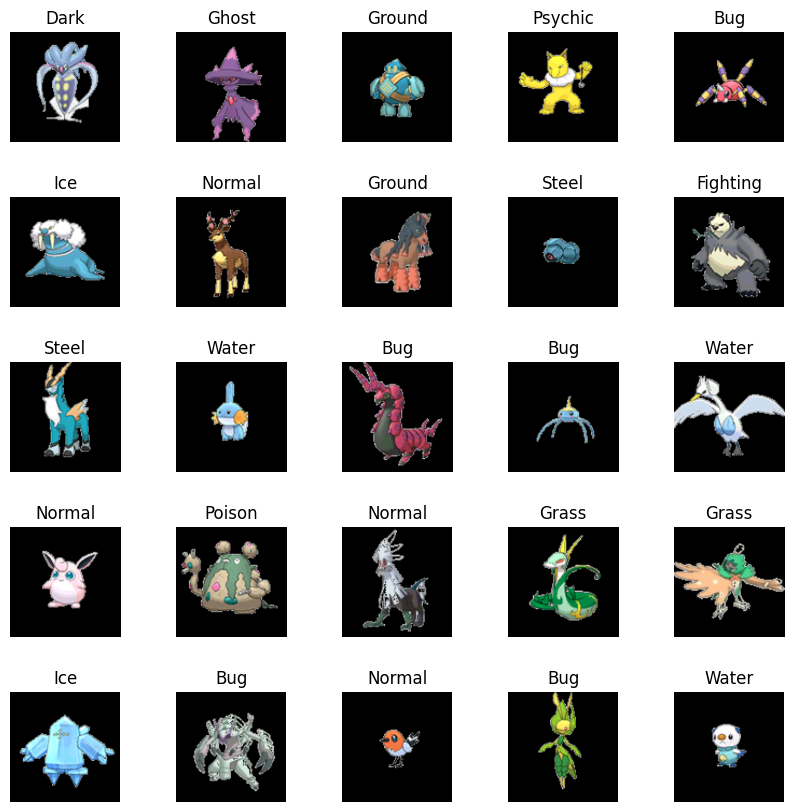

In [18]:
# Visualize data 
# Define function that plots multiple images in an array of images
def PlotImages(ix_start,num_img,rows,cols,images,labels,color=True):
    plt.figure(figsize=(10,10))
    plt.subplots_adjust(wspace=0.5,hspace=0.5)
    for i in range(num_img):
        plt.subplot(rows,cols,i+1)
        plt.axis('off')
        if color:
            plt.imshow(images.permute(0, 2, 3, 1)[ix_start+i])
        else: 
            plt.imshow(np.squeeze(images[ix_start+i]),cmap='Greys')
        plt.title(pokemon_type_list[labels[ix_start+i].item()])

# Image loader and scaler for image exploration
explorer_batch_size = 25
load_image = transforms.Compose([
    transforms.Resize((px, px)),
    transforms.ToTensor()
])
dataset = PokemonSingleTypeDataset(path_to_type_csv, image_directory, transform=load_image)
dataloader = DataLoader(dataset, batch_size=explorer_batch_size, shuffle=True)
data_iter = iter(dataloader)

images, labels = next(data_iter)
next(data_iter)
PlotImages(0,explorer_batch_size,5,5,images,labels,color=True)

In [19]:
# =============================================================================
# Function to create weighted sampler for handling class imbalance
# =============================================================================
def create_weighted_sampler(dataset):
    """
    Creates a weighted sampler to handle class imbalance.
    Gives more weight to underrepresented classes.
    """
    # Get all labels from dataset
    labels = [dataset[i][1] for i in range(len(dataset))]
    
    # Count samples per class
    class_counts = Counter(labels)
    print("Class distribution:")
    for cls in sorted(class_counts.keys()):
        print(f"  {pokemon_type_list[cls]}: {class_counts[cls]}")
    
    # Calculate weights (inverse frequency)
    class_weights = {cls: 1.0/count for cls, count in class_counts.items()}
    
    # Assign weight to each sample
    sample_weights = [class_weights[label] for label in labels]
    
    # Create sampler
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    
    return sampler

In [20]:
# =============================================================================
# Function to calculate class weights for loss function
# =============================================================================
def calculate_class_weights(labels, num_classes):
    """
    Calculate class weights for weighted loss function
    """
    class_counts = np.bincount(labels, minlength=num_classes)
    
    # Inverse frequency weighting
    class_weights = 1.0 / (class_counts + 1e-6)
    # Normalize weights
    class_weights = class_weights / class_weights.sum() * num_classes
    
    return torch.FloatTensor(class_weights)


In [21]:
# =============================================================================
# IMPROVED: Train full network end-to-end instead of just features
# =============================================================================

# Impot necessary libraries
from time import time
from sklearn.model_selection import train_test_split

# Load full dataset and split into train/test
full_dataset = PokemonSingleTypeDataset(path_to_type_csv, image_directory)
all_labels = [full_dataset[i][1] for i in range(len(full_dataset))]

# Split indices with stratification to maintain class distribution
train_indices, test_indices = train_test_split(
    range(len(full_dataset)), 
    test_size=0.2, 
    stratify=all_labels,
    random_state=0
)

print(f'Train size: {len(train_indices)}, Test size: {len(test_indices)}')


Train size: 647, Test size: 162


In [22]:

# This class encapsulates all the data loading and preparation steps.
class PokemonDataModule(pl.LightningDataModule):
    def __init__(self, dataset, train_indices, test_indices, batch_size=64):
        super().__init__()
        self.dataset = dataset
        self.train_indices = train_indices
        self.test_indices = test_indices
        self.batch_size = batch_size
        
        # Define transforms with augmentation for training
        self.train_transform = transforms.Compose([
            transforms.Resize((px + 20, px + 20)),
            transforms.RandomCrop((px, px)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        self.test_transform = transforms.Compose([
            transforms.Resize((px, px)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
    def setup(self, stage=None):
        # Create train and test datasets with appropriate transforms
        self.train_dataset = PokemonSingleTypeDataset(
            path_to_type_csv, image_directory, transform=self.train_transform
        )
        self.test_dataset = PokemonSingleTypeDataset(
            path_to_type_csv, image_directory, transform=self.test_transform
        )
        
        # Use subset of indices for train/test split
        self.train_subset = torch.utils.data.Subset(self.train_dataset, self.train_indices)
        self.test_subset = torch.utils.data.Subset(self.test_dataset, self.test_indices)
        
    def train_dataloader(self):
        # Create weighted sampler for training subset
        train_labels = [all_labels[i] for i in self.train_indices]
        class_counts = Counter(train_labels)
        class_weights = {cls: 1.0/count for cls, count in class_counts.items()}
        sample_weights = [class_weights[all_labels[i]] for i in self.train_indices]
        
        sampler = WeightedRandomSampler(
            weights=sample_weights,
            num_samples=len(sample_weights),
            replacement=True
        )
        return DataLoader(self.train_subset, batch_size=self.batch_size, sampler=sampler)
    
    def test_dataloader(self):
        return DataLoader(self.test_subset, batch_size=self.batch_size, shuffle=False)



In [23]:

# =============================================================================
# IMPROVED MODEL: Fine-tune VGG16 instead of frozen features
# =============================================================================
class VGG16PokemonClassifier(pl.LightningModule):
    def __init__(self, num_classes=len(pokemon_type_list), learning_rate=0.001):
        super().__init__()
        self.learning_rate = learning_rate
        
        # Load pretrained VGG16
        vgg16 = models.vgg16(weights='VGG16_Weights.DEFAULT')
        
        # Freeze early layers, unfreeze later layers for fine-tuning
        for i, param in enumerate(vgg16.features.parameters()):
            if i < 20:  # Freeze first 20 layers
                param.requires_grad = False
            else:
                param.requires_grad = True
        
        self.features = vgg16.features
        
        # Custom classifier for Pokemon types
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)
        )
        
        # Calculate class weights
        train_labels = [all_labels[i] for i in train_indices]
        class_weights = calculate_class_weights(np.array(train_labels), num_classes)
        self.criterion = nn.CrossEntropyLoss(weight=class_weights)
        
        # Track best accuracy
        self.best_acc = 0
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        
        # Calculate accuracy
        _, predicted = outputs.max(1)
        correct = (predicted == labels).sum().item()
        accuracy = correct / labels.size(0)
        
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', accuracy, prog_bar=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        
        # Calculate accuracy
        _, predicted = outputs.max(1)
        correct = (predicted == labels).sum().item()
        accuracy = correct / labels.size(0)
        
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', accuracy, prog_bar=True)
        
        return {'test_loss': loss, 'test_acc': accuracy}
    
    def configure_optimizers(self):
        # Different learning rates for features vs classifier
        optimizer = torch.optim.Adam([
            {'params': self.features.parameters(), 'lr': self.learning_rate * 0.1},
            {'params': self.classifier.parameters(), 'lr': self.learning_rate}
        ], weight_decay=1e-4)
        
        # Learning rate scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=0.5, patience=5
        )
        
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'train_acc',
                'interval': 'epoch',
                'frequency': 1,
                'reduce_on_plateau': True,
                'strict': True,
                'verbose': True,
                }
            }

In [ ]:

# Instantiate the DataModule
pokemon_data = PokemonDataModule(full_dataset, train_indices, test_indices, batch_size=batch_size)
pokemon_data.setup()

# Calculate and print class weights
train_labels = [all_labels[i] for i in train_indices]
class_weights = calculate_class_weights(np.array(train_labels), len(pokemon_type_list))
print("\nClass weights for loss function:")
for i, weight in enumerate(class_weights):
    print(f"  {pokemon_type_list[i]}: {weight:.4f}")

# Instantiate the improved model
model = VGG16PokemonClassifier(learning_rate=0.001)

# The Trainer with callbacks for better monitoring
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_callback = ModelCheckpoint(
    monitor='train_acc',
    dirpath='checkpoints/',
    filename='pokemon-{epoch:02d}-{train_acc:.2f}',
    save_top_k=3,
    mode='max'
)

early_stop_callback = EarlyStopping(
    monitor='train_acc',
    patience=15,
    mode='max',
    verbose=True
)

trainer = pl.Trainer(
    max_epochs=10,
    accelerator='gpu',
    devices=[4],
    callbacks=[checkpoint_callback, early_stop_callback],
    log_every_n_steps=10
)

# Start the training process
time_start = time()
trainer.fit(model, datamodule=pokemon_data)
time_stop = time()

print(f"\nElapsed training time: {round(time_stop - time_start, 1)} sec.")
print(f"Best training accuracy achieved: {model.best_acc:.2f}%")

# Evaluate the model on the test dataset
test_results = trainer.test(model, datamodule=pokemon_data)
print(f"\nFinal test results: {test_results}")


Class weights for loss function:
  Bug: 0.3361
  Dark: 0.8475
  Dragon: 0.8860
  Electric: 0.6091
  Fairy: 1.3923
  Fighting: 0.8475
  Fire: 0.4641
  Flying: 6.4973
  Ghost: 0.8860
  Grass: 0.3144
  Ground: 0.7497
  Ice: 1.0829
  Normal: 0.2320
  Poison: 0.7219
  Psychic: 0.4641
  Rock: 0.5268
  Steel: 0.9282
  Water: 0.2142


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/work/envs/venv/DL_gpu/lib/python3.11/site-packages/pytorch_lightning/core/optimizer.py:259: Found unsupported keys in the lr scheduler dict: {'verbose'}. HINT: remove them from the output of `configure_optimizers`.

  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | features   | Sequential       | 14.7 M | train
1 | classifier | Sequential       | 8.9 M  | train
2 | criterion  | CrossEntropyLoss | 0      | train
--------------------------------------------------------
16.0 M    Trainable params
7.6 M     Non-trainable params
23.6 M    Total params
94.553    Total estimated model params size (MB)
41        Modules in train mode
0         Modules in eval mode
/work/envs/venv/DL_gpu/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connec

Epoch 0: 100%|██████████| 26/26 [00:04<00:00,  6.10it/s, v_num=22, train_loss=2.510, train_acc=0.182]

Metric train_acc improved. New best score: 0.182


Epoch 1: 100%|██████████| 26/26 [00:03<00:00,  7.12it/s, v_num=22, train_loss=0.589, train_acc=0.318]

Metric train_acc improved by 0.136 >= min_delta = 0.0. New best score: 0.318


Epoch 2: 100%|██████████| 26/26 [00:03<00:00,  7.32it/s, v_num=22, train_loss=0.622, train_acc=0.545]

Metric train_acc improved by 0.227 >= min_delta = 0.0. New best score: 0.545


Epoch 3: 100%|██████████| 26/26 [00:03<00:00,  7.02it/s, v_num=22, train_loss=0.348, train_acc=0.682]

Metric train_acc improved by 0.136 >= min_delta = 0.0. New best score: 0.682


Epoch 4:  50%|█████     | 13/26 [00:01<00:01,  6.73it/s, v_num=22, train_loss=0.223, train_acc=0.840]


Detected KeyboardInterrupt, attempting graceful shutdown ...


SystemExit: 1

/work/envs/venv/DL_gpu/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
